In [ ]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve,auc
from sklearn.metrics import precision_score, recall_score

## Initial Data Exploration and Visualization

In [ ]:
#Reading data into DataFrame

df = pd.read_csv("Forest_data.csv")
df.shape


(286048, 11)

In [ ]:
#Calculating percentage of data points belonging to each class

percent_class_0 = ((df['Anomaly'].value_counts()[0])/df.shape[0])*100
percent_class_1 = ((df['Anomaly'].value_counts()[1])/df.shape[0])*100
print("percent entries with class 0 is", percent_class_0, "and percent entries with class 1 is", percent_class_1)

percent entries with class 0 is 99.03967166349703 and percent entries with class 1 is 0.9603283365029646


In [ ]:
#Splitting Data into Training, Validation and Test Set
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size = 0.5, random_state = 0)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']


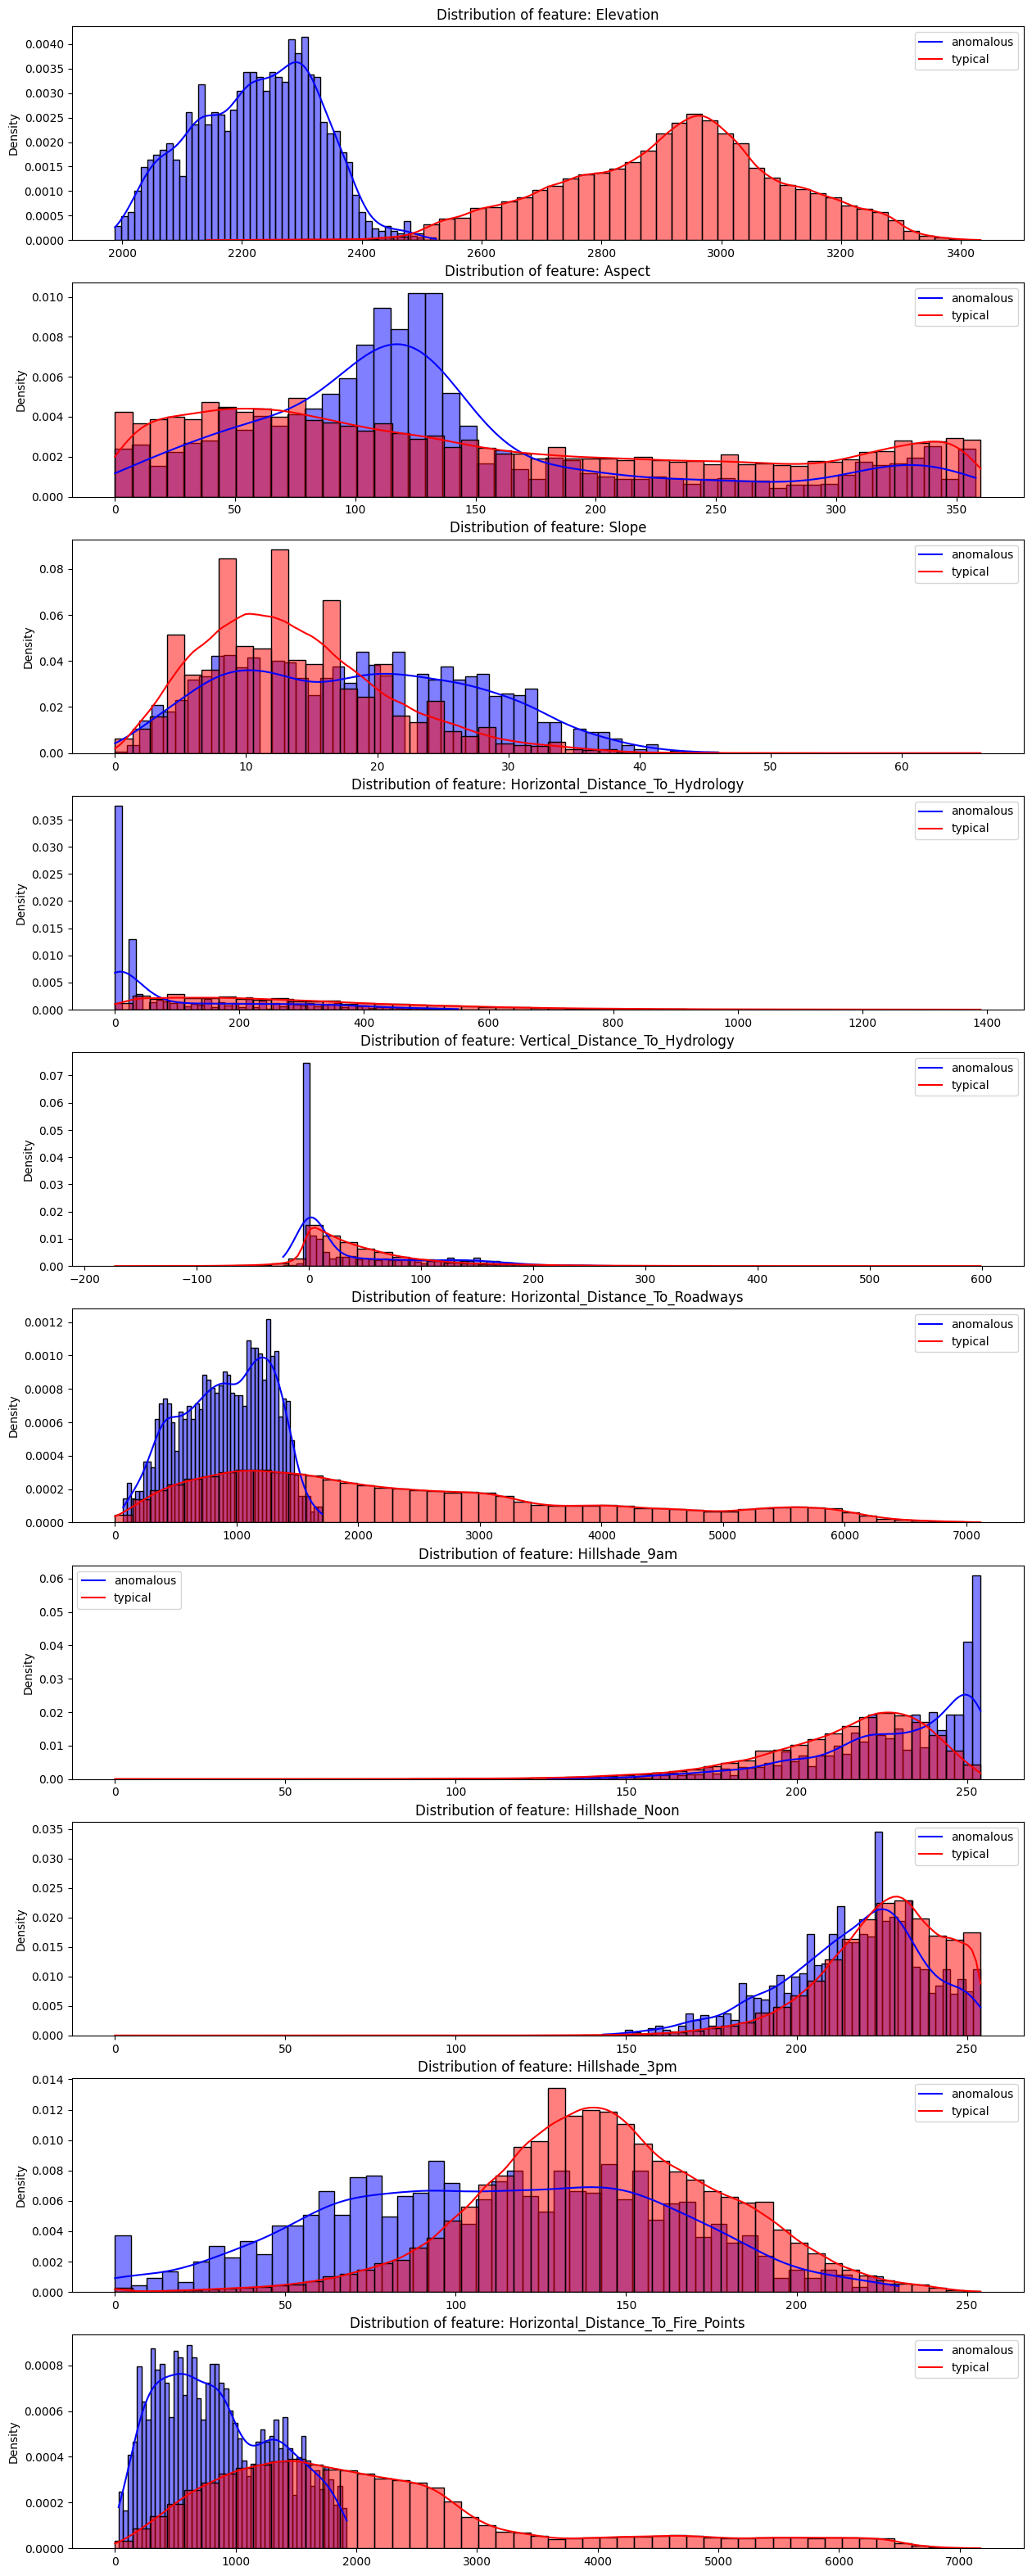

In [ ]:
#Histogram Plots Single Distributions Given

features=[f for f in df.columns if not 'Anomaly' in f]
print(features)
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['anomalous', 'typical'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

These Graphs provide an initial understanding about the spread of data within each feature. For example, in the feature Elevation, we observe that non anomalous data is distributed normally, with data centered around the mean. and the data points corresponding to anomalies are much further away from the mean of the non anomalous data, suggesting that when this feature takes certian values, it is outside the normal distribution of the non anomalous feature, which if a gaussian model is fit on the data, can help identify anomalies if the feature takes value significantly outside the expected normal distribution as the probability of a non anomalous feature taking such a value is extremely low.

The same applies to other cases, albeit, the distinction is not as clear. However, in many cases a single Gaussian Distribution provides a lot of evidence about how anomalies are on the extreme ends of what is expected to be the values of non anomalous data. therefore if the probability based on the normal distribution of non anomalous data of certain features taking a certain value is very low, it can suggest that this observed value indeed correspnds to an anamoly.

Lastly, while all points in other features may not come from a single normal distribution, but its still likely that they ccan come from more than 1 gaussian distribution. therefore if the anomalous data takes on a value that is probabilistic low, even with higher number of gaussian distributions and their individual weights, it could strongly suggest that data point is anomaly, allowing us to use gaussian models to detect anomalous feature data.

## Training GMM on 1 feature at a time with 1 component
(Calculating AUC and F-1 as our accuracy measures due to imbalanced data-set)

###Training on All Data Points including ones with Anomalous data

In [ ]:
#Converting Data to Numpy arrays

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#Defining a function to calculate AUC on training and validation for each feature

def auc_train_2a(X_train, y_train, X_val, y_val):
    train_auc = []
    val_auc = []
    feat_name = []
    column_index = []

    for i in range (X_train.shape[1]):

      feat_name.append(df.columns[i])
      column_index.append(i)
      gmm = GaussianMixture(n_components = 1, random_state = 0)
      X_train_feature = X_train[:,i].reshape(-1,1)
      gmm.fit(X_train_feature)
      scores_train = gmm.score_samples(X_train_feature)
      scores_train = -scores_train
      auc_train = roc_auc_score(y_train, scores_train)
      train_auc.append(auc_train)

      X_val_feature = X_val[:,i].reshape(-1,1)
      scores_val = gmm.score_samples(X_val_feature)
      scores_val = -scores_val
      auc_val = roc_auc_score(y_val, scores_val)
      val_auc.append(auc_val)

    df_2a1 = pd.DataFrame({'Feature Trained on' : feat_name, "column Index" : column_index, "Training AUC": train_auc, "Validation AUC": val_auc})

    return df_2a1

df_2a1 = auc_train_2a(X_train, y_train, X_val, y_val)


In [ ]:
#Sorting by each validation AUC to get top 3 best features and outputting result

df_2a1 = df_2a1.sort_values(by = 'Validation AUC', ascending = False).reset_index(drop = True)
top3_index = df_2a1.iloc[:3,1]
top3_index = top3_index.to_list()
df_2a1.iloc[:3,:]

,Feature Trained on,column Index,Training AUC,Validation AUC
0,Elevation,0,0.999357,0.999345
1,Horizontal_Distance_To_Fire_Points,9,0.672193,0.681883
2,Hillshade_3pm,8,0.658451,0.660931


In [ ]:
A Defining a function to get F-1 Values for our top 3 selected features

def f1_scores(X_train,X_val, y_val,top3_index):
  feat_name = []
  column_index = []
  max_f1_score = []
  opt_tr = []

  for i in top3_index:
    column_index.append(i)
    feat_name.append(df.columns[i])

    gmm = GaussianMixture(n_components = 1, random_state = 0)
    gmm.fit(X_train[:,i].reshape(-1,1))
    X_val_feature = X_val[:,i].reshape(-1,1)
    scores = gmm.score_samples(X_val_feature)

    threshold_list = np.unique(scores)

    max_f1 = 0

    for i in range(threshold_list.shape[0]):
      tr = threshold_list[i]
      f1_value = f1_score(y_val, scores < tr)

      if f1_value > max_f1:
        max_f1 = f1_value
        max_tr = tr

    max_f1_score.append(max_f1)
    opt_tr.append(tr)

  df_2a2 = pd.DataFrame({'Feature Name' : feat_name, 'Column Index' : column_index, 'Max F1 Validation' : max_f1_score, 'Optimal threshold Validation' : opt_tr})

  return df_2a2

df_2a2 = f1_scores(X_train, X_val, y_val, top3_index)


In [ ]:
# DataFrame with Results of F1 scores for Top 3 features
df_2a2

,Feature Name,Column Index,Max F1 Validation,Optimal threshold Validation
0,Elevation,0,0.899083,-6.208170
1,Horizontal_Distance_To_Fire_Points,9,0.035362,-8.181058
2,Hillshade_3pm,8,0.102004,-4.516148


Complexity in Big O notation for determining optimal threshold for F-1 Score:

- If we just consider the threshold determination, it is O(n) because we need to loop through atleast every single value of the scores of the validation data to receive the information about the best threshold for choosing. However, by removing the duplicate scores, we do significantly reduce the input size of the the threshold list. If no duplicated were present it would be O(n) with n being the entire size of the validation threshold list as we need to loop over all values to determine the unique values in the first place.

- In actually the complexity of calculating the optimal threshold is O(n^2), because f1_score inherently, would have to compare every single value in X_val to the threshold selected to determine the TP,FP and FN, and this process is repeated for every single unique threshold. making the complexity of determining the optimal threshold that leads to maximum F-1 score as O(n^2).

- This does not account for the fitting of the model and getting the score samples. This is simply the complexity of getting the optimal threshold corresponding to the optimal threshold.


###Training our GMM on Non Anomalous Data and comparing F-1 and AUC with previous data model.

In [ ]:
#Getting X_train data corresponding only with non anomalous data

anomaly_index_train = np.argwhere(y_train == 1)
X_train_2b = np.delete(X_train, anomaly_index_train, axis = 0)

In [ ]:
#Defining a function that calculates F1 and AUC scores in one function for top 3 features

def auc_f1(X_train_2b, X_train, X_val, y_train, y_val, index):

    train_auc = []
    val_auc = []
    feat_name = []
    column_index = []
    max_f1_score = []
    opt_tr = []

    for i in index:

      feat_name.append(df.columns[i])
      column_index.append(i)

      gmm = GaussianMixture(n_components = 1, random_state = 0)

      train_feat = X_train_2b[:,i].reshape(-1,1)
      gmm.fit(train_feat)
      scores_train = gmm.score_samples(X_train[:,i].reshape(-1,1))

      scores_train = gmm.score_samples(X_train[:,i].reshape(-1,1))
      scores_train_auc = -scores_train
      auc_train = roc_auc_score(y_train, scores_train_auc)
      train_auc.append(auc_train)

      scores_val = gmm.score_samples(X_val[:,i].reshape(-1,1))
      scores_val_auc = -scores_val
      auc_val = roc_auc_score(y_val, scores_val_auc)
      val_auc.append(auc_val)

      threshold_list = np.unique(scores_val)
      max_f1 = 0

      for i in range(threshold_list.shape[0]):
        tr = threshold_list[i]
        f1_value = f1_score(y_val, scores_val < tr)

        if f1_value > max_f1:
          max_f1 = f1_value
          max_tr = tr

      max_f1_score.append(max_f1)
      opt_tr.append(tr)


    df_2b1 = pd.DataFrame({'Feature Trained Non Anomaly' : feat_name,
                           "column Index Non Anomaly" : column_index,
                           "Training AUC Non Anomaly": train_auc,
                           "Validation AUC Non Anomaly": val_auc,
                           "Max F1 Non Anomaly": max_f1_score,
                           "Optimal threshold Non Anomaly": opt_tr})

    return df_2b1

In [ ]:
df_2b1 = auc_f1(X_train_2b, X_train, X_val, y_train, y_val, top3_index)

In [ ]:
df_q2_comp = pd.concat([df_2a1.iloc[:3,:], df_2a2, df_2b1], axis = 1).drop(columns = ['Feature Trained Non Anomaly', 'column Index Non Anomaly', 'Feature Name', 'Column Index'])
df_q2_comp

,Feature Trained on,column Index,Training AUC,Validation AUC,Max F1 Validation,Optimal threshold Validation,Training AUC Non Anomaly,Validation AUC Non Anomaly,Max F1 Non Anomaly,Optimal threshold Non Anomaly
0,Elevation,0,0.999357,0.999345,0.899083,-6.208170,0.999368,0.999359,0.899083,-6.148540
1,Horizontal_Distance_To_Fire_Points,9,0.672193,0.681883,0.035362,-8.181058,0.674435,0.683989,0.035520,-8.181255
2,Hillshade_3pm,8,0.658451,0.660931,0.102004,-4.516148,0.659193,0.661321,0.103800,-4.508504


In [ ]:
#Printing Mean and Standard deviation of the data in each feature.
for i in top3_index:
  print(X_train[:,i].mean(), X_train[:,i].std(), X_train_2b[:,i].mean(),X_train_2b[:,i].std())


2914.192905265366 198.1909068519041 2920.92578920827 186.71829644818501
2158.273571289448 1425.273638902285 2170.978663640948 1425.5552068438408
142.7149820459165 36.49515065405309 143.0225113464448 36.218340340933445


The results are extremely similar, for the training and validation AUC as well as the maximum F1 on validation and the optimal threshold. This is because even after training the data on non anomalous data the mean and the standard deviation of the model we fit our single Gaussian with 1 component did not change. This is evidenced above.

As, this is only 1 component and 1 feature, the expectation maximization parameters is the mean and the standard deviation of the feature itself. Therefore,the distribution we fit remains the same among both a) and b) for each feature. Therefore the scores we receive for each point will be very similar for both cases. As the scores are similar, this gives similar AUC for training and validattion as well as similar F-1 on validation data for both models.

## Using the Precision Recall Curve:


In [ ]:
#Defining a function to calculate training and val AUC for PR on all features as 2a1.

def auc_train_bonus(X_train, y_train, X_val, y_val):
    train_auc = []
    val_auc = []
    feat_name = []
    column_index = []

    for i in range (X_train.shape[1]):

      feat_name.append(df.columns[i])
      column_index.append(i)
      gmm = GaussianMixture(n_components = 1, random_state = 0)
      X_train_feature = X_train[:,i].reshape(-1,1)
      gmm.fit(X_train_feature)

      scores_train = gmm.score_samples(X_train_feature)
      scores_train = -scores_train
      precision_train, recall_train, threshold_train = precision_recall_curve(y_train, scores_train)
      auc_train = auc(recall_train,precision_train)
      train_auc.append(auc_train)

      X_val_feature = X_val[:,i].reshape(-1,1)
      scores_val = gmm.score_samples(X_val_feature)
      scores_val = -scores_val
      precision_val, recall_val, threshold_val = precision_recall_curve(y_val, scores_val)
      auc_val = auc(recall_val,precision_val)
      val_auc.append(auc_val)

    df_2a1_bonus = pd.DataFrame({'Feature Trained on PR' : feat_name, "column Index PR" : column_index, "Training PR": train_auc, "Validation PR": val_auc})

    return df_2a1_bonus

df_2a1_bonus = auc_train_bonus(X_train, y_train, X_val, y_val)


In [ ]:
df_2a1_bonus = df_2a1_bonus.sort_values(by = 'Validation PR', ascending = False).reset_index(drop = True)
top3_index_bonus = df_2a1_bonus.iloc[:3,1]
df_2a1_bonus

,Feature Trained on PR,column Index PR,Training PR,Validation PR
0,Elevation,0,0.929641,0.931009
1,Hillshade_3pm,8,0.038884,0.041211
2,Slope,2,0.022741,0.023350
3,Horizontal_Distance_To_Hydrology,3,0.015886,0.015434
4,Hillshade_9am,6,0.015488,0.015258
5,Horizontal_Distance_To_Fire_Points,9,0.014045,0.014095
6,Hillshade_Noon,7,0.013335,0.014047
7,Vertical_Distance_To_Hydrology,4,0.013475,0.013035
8,Horizontal_Distance_To_Roadways,5,0.011179,0.010731
9,Aspect,1,0.007246,0.007220


In [ ]:
#Getting F-1 scores on validation data - but features now change because validation AUC for PR is different for features

df_2a2_bonus = f1_scores(X_train,X_val, y_val, top3_index_bonus)
df_2a2_bonus

,Feature Name,Column Index,Max F1 Validation,Optimal threshold Validation
0,Elevation,0,0.899083,-6.208170
1,Hillshade_3pm,8,0.102004,-4.516148
2,Slope,2,0.074774,-2.884725


In [ ]:
#Removing data corresponding with anomalies to prepare for training data for bonus part.

anomaly_index_train = np.argwhere(y_train == 1)
X_train_2b_bonus = np.delete(X_train, anomaly_index_train, axis = 0)

In [ ]:
#Defining function to get f-1 and AUC after fitting on data without anomalies, but now using PR curve.

def auc_f1_bonus(X_train_2b, X_train, X_val, y_train, y_val, index):

    train_auc = []
    val_auc = []
    feat_name = []
    column_index = []
    max_f1_score = []
    opt_tr = []

    for i in index:

      feat_name.append(df.columns[i])
      column_index.append(i)

      gmm = GaussianMixture(n_components = 1, random_state = 0)

      train_feat = X_train_2b[:,i].reshape(-1,1)
      gmm.fit(train_feat)
      scores_train = gmm.score_samples(X_train[:,i].reshape(-1,1))
      scores_train_auc = -scores_train

      precision_train, recall_train, threshold_train = precision_recall_curve(y_train, scores_train_auc)
      auc_train = auc(recall_train,precision_train)
      train_auc.append(auc_train)

      scores_val = gmm.score_samples(X_val[:,i].reshape(-1,1))
      scores_val_auc = -scores_val
      precision_val, recall_val, threshold_val = precision_recall_curve(y_val, scores_val_auc)
      auc_val = auc(recall_val,precision_val)
      val_auc.append(auc_val)

      threshold_list = np.unique(scores_val)
      max_f1 = 0

      for i in range(threshold_list.shape[0]):
        tr = threshold_list[i]
        f1_value = f1_score(y_val, scores_val < tr)

        if f1_value > max_f1:
          max_f1 = f1_value
          max_tr = tr

      max_f1_score.append(max_f1)
      opt_tr.append(tr)


    df_2b1_bonus = pd.DataFrame({'Feature Trained Non Anomaly PR' : feat_name,
                           "column Index Non Anomaly PR" : column_index,
                           "Training AUC Non Anomaly PR": train_auc,
                           "Validation AUC Non Anomaly PR": val_auc,
                           "Max F1 Non Anomaly PR": max_f1_score,
                           "Optimal threshold Non  PR": opt_tr})

    return df_2b1_bonus

In [ ]:
#Receiving F-1 scores on VAL and AUC for training and Val for top 3 features but using PR curve and fitting on non anomalous daata
df_2b1_bonus = auc_f1_bonus(X_train_2b_bonus, X_train, X_val, y_train, y_val, top3_index_bonus)
df_2b1_bonus

,Feature Trained Non Anomaly PR,column Index Non Anomaly PR,Training AUC Non Anomaly PR,Validation AUC Non Anomaly PR,Max F1 Non Anomaly PR,Optimal threshold Non PR
0,Elevation,0,0.929998,0.931317,0.899083,-6.148540
1,Hillshade_3pm,8,0.039330,0.041632,0.103800,-4.508504
2,Slope,2,0.022741,0.023350,0.074774,-2.879358


The results are a bit different from the previous question. This is because we are now focusing on accuracy measures that relate purely to the ability of the model to seperate the positive (anomaly) class which is what we wanted our model to initially do. The lower validation AUC for PR curve for both non anomalous fitting and all fitting is because the PR curve shows how well the model quantifies the seperation of the positive class, in terms of the precision and Recall.

In ROC, we only focus on recall related to the positive class which suggests how many positive classes we missed to quantify, and FPR on the x axis which suggests how many true negatives we classified as FPR, and therefore how well we distinguished between the two seperate classes which gives a more balanced performance of seperation between both classes.

However, the PR curve helps identify how well the model distinguishes the positive class in terms of miss and inaccuracy of identification, which is what is more valid for our case, as identifying anomalies is more important for us due to the imbalanced classes.

Also, the features we find for F-1 change, because the Slope feature is better than feature index 9, in seperating the positive class as determined by the validation AUC.

## Multiple feature model with one Gaussian distribution with varying number of componenets:





In [ ]:
#Defining function which will calculate two-variate distribution, AUC on training and val, and F-1 on Val with our choice of components.

def auc_f1_q3(X_train, X_val, y_train, y_val, index, n):

    train_auc = []
    val_auc = []
    feat_name = []
    column_index = []
    max_f1_score = []
    opt_tr = []

    for i in index:
      print(i)

      feat_name.append(df.columns[i])
      column_index.append(i)

      print(df.columns[i])

      gmm = GaussianMixture(n_components = n, random_state = 0)

      train_feat = X_train[:,i]
      print(train_feat)
      gmm.fit(train_feat)
      scores_train = gmm.score_samples(X_train[:,i])
      scores_train_auc = -scores_train
      auc_train = roc_auc_score(y_train, scores_train_auc)
      train_auc.append(auc_train)

      scores_val = gmm.score_samples(X_val[:,i])
      scores_val_auc = -scores_val
      auc_val = roc_auc_score(y_val, scores_val_auc)
      val_auc.append(auc_val)

      threshold_list = np.unique(scores_val)
      print(threshold_list.shape)
      max_f1 = 0

      for i in range(threshold_list.shape[0]):
        tr = threshold_list[i]
        f1_value = f1_score(y_val, scores_val < tr)

        if f1_value > max_f1:
          max_f1 = f1_value
          max_tr = tr

      max_f1_score.append(max_f1)
      opt_tr.append(max_tr)


    return column_index, feat_name, train_auc, val_auc, max_f1, opt_tr, scores_val

In [ ]:
#Setting color for anomalous and non anomalous data for identification on plot
color = ['red' if x == 1 else 'blue' for x in y_train]


The four pair of features I chose were:
1. "Elevation vs Aspect
2. Elevation vs Hillside 3PM
3. Elevation vs Horizontal Distance to Fire Points
4. Elevation vs Hillside 9AM

This is because the combination of the features provided the most distinct sepepration of the anomalous and valid forest classes

Text(0, 0.5, 'Aspect')

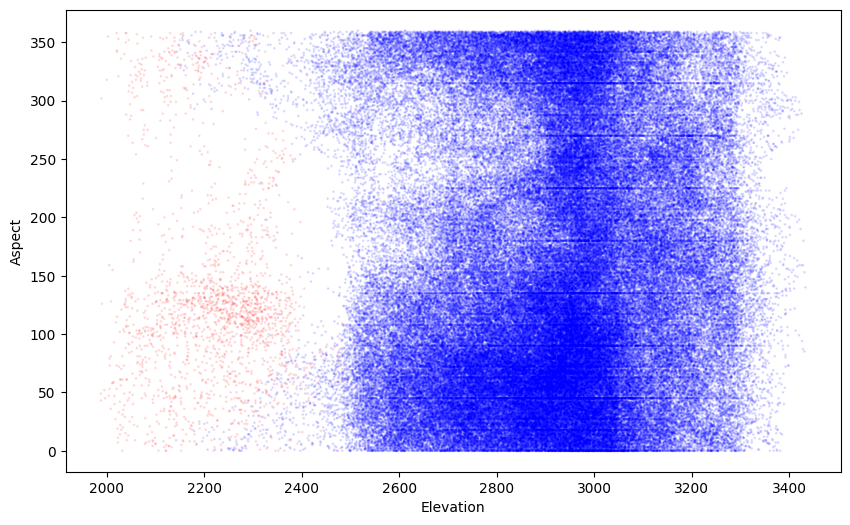

In [ ]:
#Plot 1 - Elevation vs Aspect

plt.figure(figsize = (10,6))
plt.scatter(X_train[:,0], X_train[:,1], c = color, s = 1, alpha = 0.1)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])

In [ ]:
#Plot 1- AUC and F1 for data
i_01, feat_01, train_auc_01, val_auc_01, max_f1_01, max_tr_01,scores_val_01 = auc_f1_q3(X_train, X_val, y_train, y_val, [[0,1]], 2)

[0, 1]
Index(['Elevation', 'Aspect'], dtype='object')
[[2765  114]
 [2853   45]
 [3353  287]
 ...
 [3233  158]
 [2832  117]
 [3105  274]]
(38200,)


Explanation:

It is mostly evident that the valid forests form 2 seperate gaussian distributions as data is spread out in two different sides on top and bottom. As gaussian distributions will be spherical in shape, we can state that is not just 1 gaussian. It could be 3 gaussians with 1 gaussian in the middle but the density of points in that region make it hard to say. therefore,  I will choose 2 gaussian's to fit the data.

Text(0, 0.5, 'Hillshade_3pm')

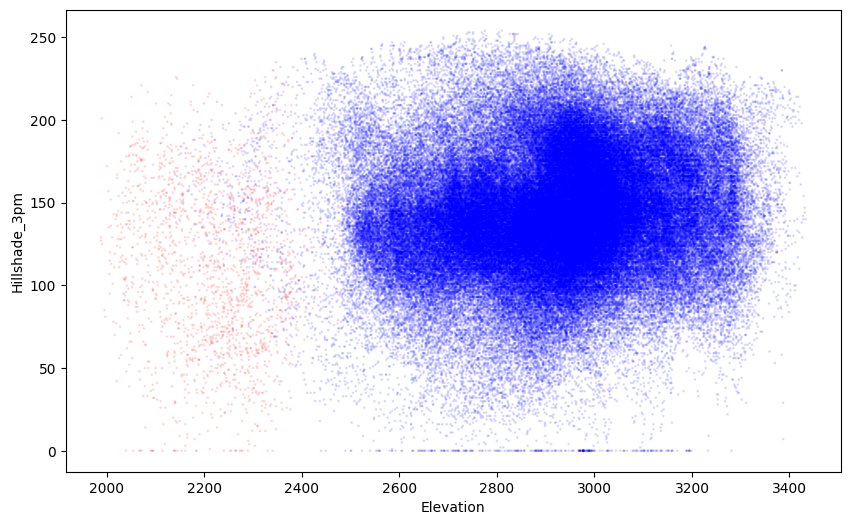

In [ ]:
#Plot 2 - Elevation vs Hillside_3PM

plt.figure(figsize = (10,6))
plt.scatter(X_train[:,0], X_train[:,8], c = color, s = 1, alpha = 0.1)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[8])

In [ ]:
#Plot 2- AUC and F1 for data
i_02, feat_02, train_auc_02, val_auc_02, max_f1_02, max_tr_02, scores_val_02= auc_f1_q3(X_train, X_val, y_train, y_val, [[0,8]], 1)

[0, 8]
Index(['Elevation', 'Hillshade_3pm'], dtype='object')
[[2765   77]
 [2853  145]
 [3353  193]
 ...
 [3233  131]
 [2832  129]
 [3105  198]]
(33478,)


Explanation:

I will be fitting 1 component on this plot and selection of features. As we can see, the valid forests form one spherical distribution, with density near the mean and the values spread out from the center of the mean. Therefore, the data will be fit on 1 component as 1 component seems to adequately decribe the spread of the data points here.

There could be more distributions where the sprad in the middle could not be clear as values could be overlapping. the density does not make this part very clear. from observation itself it seems as if the data is distributed adequately with 1 normal distribution.

Text(0, 0.5, 'Horizontal_Distance_To_Fire_Points')

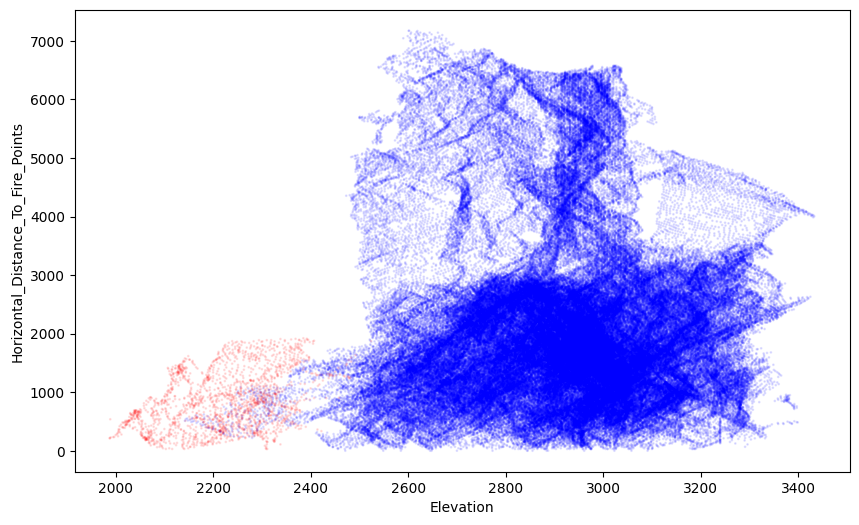

In [ ]:
#Plot 3 - Elevation vs Horizontal Distance to Fire Points

plt.figure(figsize = (10,6))
plt.scatter(X_train[:,0], X_train[:,9], c = color, s = 1, alpha = 0.1)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[9])

In [ ]:
#Plot 3 - AUC and F1 Score
i_03, feat_03, train_auc_03, val_auc_03, max_f1_03, max_tr_03, scores_val_03 = auc_f1_q3(X_train, X_val, y_train, y_val, [[0,9]], 2)

[0, 9]
Index(['Elevation', 'Horizontal_Distance_To_Fire_Points'], dtype='object')
[[2765  552]
 [2853 2061]
 [3353 2352]
 ...
 [3233 2977]
 [2832 1590]
 [3105 2325]]
(42158,)


Explanation: With the valid forests, the data looks to be able to be approximated by 2 gaussian distributions. 1 in the bottom with the centroid near (2900, 1500), and the values spread out from there. the other cluster seems to be formed at the top of the graph where there is a vertical spread with a centroid around (2900 4500) of data with spread of valid points around it. Therefore it seems that the number of components for this gmm is 2 to adequately fit this data.

Text(0, 0.5, 'Hillshade_9am')

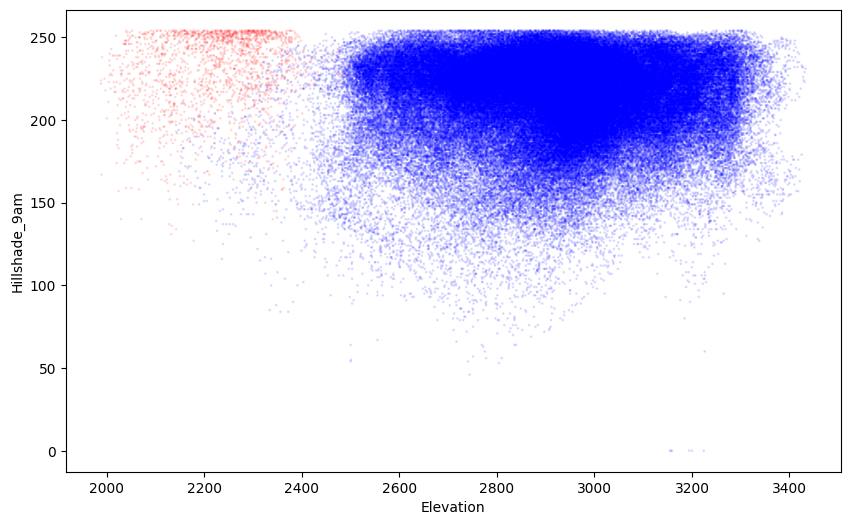

In [ ]:
#Plot 4 - Elevation vs Hillside 9AM
plt.figure(figsize = (10,6))
plt.scatter(X_train[:,0], X_train[:,6], c = color, s = 1, alpha = 0.1)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[6])

In [ ]:
#Plot #4 AUC and F1 Score

i_04, feat_04, train_auc_04, val_auc_04, max_f1_04, max_tr_04, scores_val_04 = auc_f1_q3(X_train, X_val, y_train, y_val, [[0,6]], 1)

[0, 6]
Index(['Elevation', 'Hillshade_9am'], dtype='object')
[[2765  251]
 [2853  221]
 [3353  186]
 ...
 [3233  235]
 [2832  235]
 [3105  184]]
(29314,)


Explanation:

The valid data on the plot very clearly seems to be approximated by 1 component as there is clear concentration near the mean and data points being spread out from the centroid. Meaning that this valid data forests can be adequately represented by 1 component which is what we will be fitting the data on.

In [ ]:
combined_q3_df  = pd.DataFrame({'Column Indices' : [i_01, i_02, i_03, i_04], 'Feature Pair' : [feat_01, feat_02, feat_03, feat_04], 'Training AUC' : [train_auc_01, train_auc_02, train_auc_03, train_auc_04],
              'Validation Accuracy' : [val_auc_01, val_auc_02, val_auc_03, val_auc_04], 'Max F1 Score' : [max_f1_01, max_f1_02, max_f1_03, max_f1_04],
              'Optimal Threshold' : [max_tr_01, max_tr_02, max_tr_03, max_tr_04]})

tr_array = np.array([max_tr_01, max_tr_02, max_tr_03, max_tr_04])

combined_q3_df

,Column Indices,Feature Pair,Training AUC,Validation Accuracy,Max F1 Score,Optimal Threshold
0,"[[0, 1]]","[[Elevation, Aspect]]",[0.9967666943463308],[0.9973058978015064],0.804762,[-16.114850427867523]
1,"[[0, 8]]","[[Elevation, Hillshade_3pm]]",[0.9957381456816463],[0.9956899955576811],0.690391,[-16.5829591598819]
2,"[[0, 9]]","[[Elevation, Horizontal_Distance_To_Fire_Points]]",[0.9948944559537236],[0.9950688978739533],0.676278,[-19.331200114062437]
3,"[[0, 6]]","[[Elevation, Hillshade_9am]]",[0.9907562261634655],[0.9905768445465585],0.497011,[-15.97906674451489]


In [ ]:
scores_val_01[scores_val_01 < tr_array[0]].size

scores_val_01.max()

-11.487487776553776

Text(0, 0.5, 'Aspect')

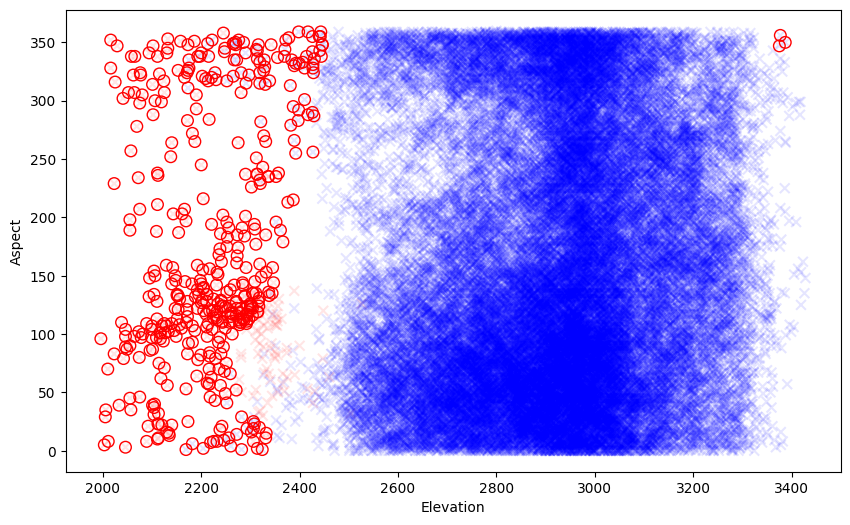

In [ ]:
#Outlier Plots on Validation Data

color = ['red' if x == 1 else 'blue' for x in y_val]

#plot 1 - Elevation vs Aspect

plt.figure(figsize=(10,6))
plt.scatter(X_val[:,0],X_val[:,1],marker="x",c=color,s = 50, alpha = 0.1);
outliers = np.nonzero(scores_val_01<tr_array[0])[0] #indices for which p<tr
plt.scatter(X_val[outliers,0],X_val[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])


Text(0, 0.5, 'Hillshade_3pm')

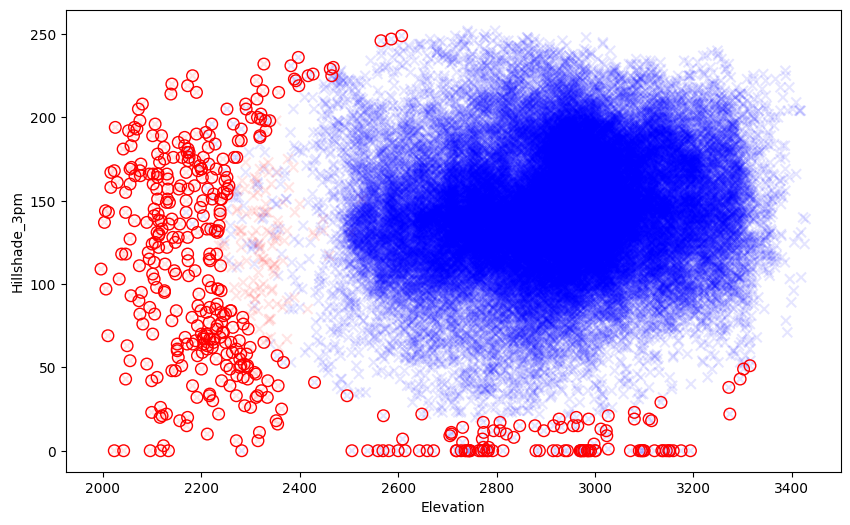

In [ ]:
#Plot 2 -  Elevation vs Hillside_3PM

plt.figure(figsize=(10,6))
plt.scatter(X_val[:,0],X_val[:,8],marker="x",c=color,s = 50, alpha = 0.1);
outliers = np.nonzero(scores_val_02<tr_array[1])[0] #indices for which p<tr
plt.scatter(X_val[outliers,0],X_val[outliers,8],marker="o",facecolor="none",edgecolor="r",s=70);
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[8])


Text(0, 0.5, 'Horizontal_Distance_To_Fire_Points')

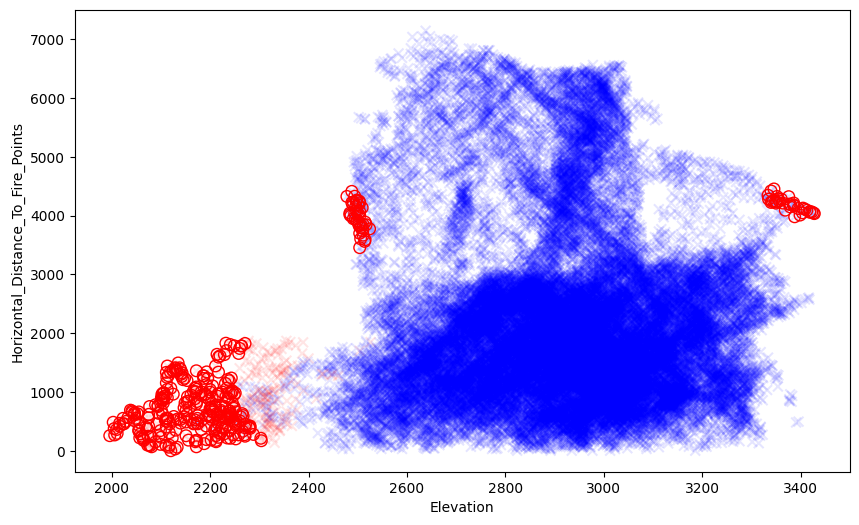

In [ ]:
#Plot 3 -  Elevation vs Horizontal Distance to Fire Points

plt.figure(figsize=(10,6))
plt.scatter(X_val[:,0],X_val[:,9],marker="x",c=color,s = 50, alpha = 0.1);
outliers = np.nonzero(scores_val_03<tr_array[2])[0] #indices for which p<tr
plt.scatter(X_val[outliers,0],X_val[outliers,9],marker="o",facecolor="none",edgecolor="r",s=70);
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[9])


Text(0, 0.5, 'Hillshade_9am')

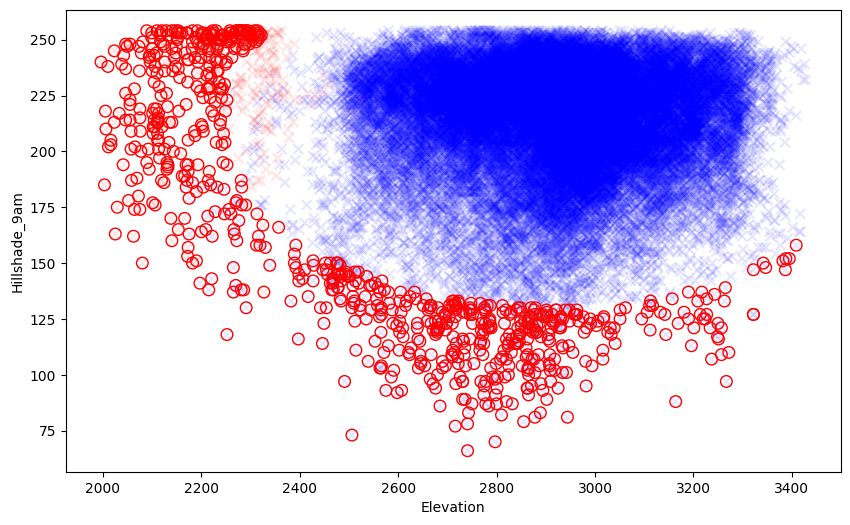

In [ ]:
#Plot 4 - Elevation vs Hillside 9AM

plt.figure(figsize=(10,6))
plt.scatter(X_val[:,0],X_val[:,6],marker="x",c=color,s = 50, alpha = 0.1);
outliers = np.nonzero(scores_val_04<tr_array[3])[0] #indices for which p<tr
plt.scatter(X_val[outliers,0],X_val[outliers,6],marker="o",facecolor="none",edgecolor="r",s=70);
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[6])


## Single feature model with two Gaussian distributions. One fit on Anomalous Data and one on Non Anomalous Data


In [ ]:
def q4_f1(X_train, X_val, y_train, y_val):

  feat_name = []
  column_index = []
  f1_feat = []
  optimal_c = []

  X_train_valid = np.delete(X_train, np.argwhere(y_train == 1), axis = 0)
  X_train_anom = np.delete(X_train, np.argwhere(y_train == 0), axis = 0)

  for i in range(X_train.shape[1]):

    feat_name.append(df.columns[i])
    column_index.append(i)

    G1 = GaussianMixture(n_components = 1, random_state = 0)
    G1.fit(X_train_valid[:,i].reshape(-1,1))
    S1 = G1.score_samples(X_val[:, i].reshape(-1,1))

    G2 = GaussianMixture(n_components = 1, random_state  = 0)
    G2.fit(X_train_anom[:,i].reshape(-1,1))
    S2 = G2.score_samples(X_val[:,i].reshape(-1,1))

    max_f1 = 0
    c = 0

    for k in np.arange(0,10.1,0.1):
      f1_value = f1_score(y_val, S1 < k*S2)
      if max_f1 < f1_value:
        max_f1 = f1_value
        c = k

    f1_feat.append(max_f1)
    optimal_c.append(c)

  return feat_name, column_index, f1_feat, optimal_c


In [ ]:
feat_q4, col_idx_q4, max_f1_q4, opt_c_q4 = q4_f1(X_train, X_val, y_train, y_val)

In [ ]:
q4_df = pd.DataFrame({'Feature Name Q4' : feat_q4, 'Column Index Q4' : col_idx_q4, 'Max F1 Q4' : max_f1_q4, 'Optimal c Value' : opt_c_q4}).sort_values('Max F1 Q4', ascending = False)

In [ ]:
q4_df

,Feature Name Q4,Column Index Q4,Max F1 Q4,Optimal c Value
0,Elevation,0,0.895833,1.6
8,Hillshade_3pm,8,0.120446,1.3
2,Slope,2,0.069171,1.4
6,Hillshade_9am,6,0.051305,1.1
5,Horizontal_Distance_To_Roadways,5,0.051149,1.1
9,Horizontal_Distance_To_Fire_Points,9,0.047989,1.2
3,Horizontal_Distance_To_Hydrology,3,0.042486,1.1
7,Hillshade_Noon,7,0.040019,1.2
4,Vertical_Distance_To_Hydrology,4,0.024114,1.0
1,Aspect,1,0.021558,1.0


Answer for last question:

After iterating through c values, we receive the maximum F-1 Score on the feature Elevation with a c value of 1.6 and F-1 score of 89.583% on the validation data set.

##  Multivariate and Mixture of Gaussians Distribution - 10 Models to find Optimal Testing Accuracy




In [ ]:
def q5_c_tune_model(X_train, X_val, y_train, y_val, features_index, n_valid, n_anomaly):

  feat_name = []
  no_of_features = []
  f1_train = []
  f1_val = []
  optimal_c_train = []
  optimal_c_val = []
  n_valid_value = []
  n_anomaly_value = []
  n_gaussians = []
  looped_valid_n= []
  looped_anom_n = []
  column_index = []

  X_train_model = X_train[:, features_index]
  X_val_model = X_val[:, features_index]
  X_train_valid = np.delete(X_train_model, np.argwhere(y_train == 1), axis = 0)
  X_train_anom = np.delete(X_train_model, np.argwhere(y_train == 0), axis = 0)

  if X_train_model.shape[1] == 1:

    X_train_model = X_train_model.reshape(-1,1)
    X_val_model = X_val_model.reshape(-1,1)
    X_train_valid = X_train_valid.reshape(-1,1)
    X_train_anom = X_train_anom.reshape(-1,1)

  for i in range (1, n_valid +1):
    for j in range (1, n_anomaly +1):

      max_f1_train = 0
      c_train = 0
      max_f1_val = 0
      c_val = 0
      G1 = GaussianMixture(n_components = i, random_state = 0)
      G1.fit(X_train_valid)
      S1_train = G1.score_samples(X_train_model)
      S1_val = G1.score_samples(X_val_model)

      G2 = GaussianMixture(n_components = j, random_state  = 0)
      G2.fit(X_train_anom)
      S2_train = G2.score_samples(X_train_model)
      S2_val = G2.score_samples(X_val_model)

      for k in np.arange(0,5,0.2):

        f1_value_train = f1_score(y_train, S1_train < k*S2_train)
        f1_value_val   = f1_score(y_val, S1_val < k*S2_val)

        if max_f1_train < f1_value_train:
          max_f1_train = f1_value_train
          c_train = k

        if max_f1_val < f1_value_val:
          max_f1_val = f1_value_val
          c_val = k

      f1_train.append(max_f1_train)
      f1_val.append(max_f1_val)
      optimal_c_train.append(c_train)
      optimal_c_val.append(c_val)
      n_valid_value.append(i)
      n_anomaly_value.append(j)
      feat_name.append(df.columns[features_index])
      no_of_features.append(len(features_index))
      n_gaussians.append(2)
      looped_valid_n.append(n_valid)
      looped_anom_n.append(n_anomaly)
      column_index.append(features_index)


  model_stats = pd.DataFrame({'Feature Name' : feat_name, 'Column Index' : column_index, 'No. features' : no_of_features,
                              'Range of valid n comp' : looped_valid_n, ' Range of anom n comp': looped_anom_n, 'compon valid' : n_valid_value,
                              'compon anom' : n_anomaly_value, 'Max F1 Train' : f1_train,
                              'optimal c train' : optimal_c_train, 'Max F1 Val' : f1_val, 'optimal c val' : optimal_c_val})



  return model_stats

In [ ]:
model1_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,2,3,4,5,6,7,8,9], 3, 5)
model1_best = model1_stats.loc[model1_stats['Max F1 Val'] == model1_stats['Max F1 Val'].max()]
model1_best.shape

(1, 11)

In [ ]:
model1_best = model1_stats.loc[model1_stats['Max F1 Val'] == model1_stats['Max F1 Val'].max()]
model1_best.shape

(1, 11)

In [ ]:
model2_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3,5,7,9], 3, 5)
model2_best = model2_stats.loc[model2_stats['Max F1 Val'] == model2_stats['Max F1 Val'].max()]
model2_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,3,5,1,3,0.952305,1.2,0.949622,1.2
3,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,3,5,1,4,0.957509,1.2,0.949622,1.2


In [ ]:
model2_best.shape

(2, 11)

In [ ]:
model3_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3,5,7,9], 5,1)
model3_best = model3_stats.loc[model3_stats['Max F1 Val'] == model3_stats['Max F1 Val'].max()]
model3_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
0,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,5,1,1,1,0.867129,1.2,0.880519,1.2


In [ ]:
model3_best.shape

(1, 11)

In [ ]:
model4_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3,5,7,9], 1,5)
model4_best = model4_stats.loc[model4_stats['Max F1 Val'] == model4_stats['Max F1 Val'].max()]
model4_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,5,1,3,0.952305,1.2,0.949622,1.2
3,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,5,1,4,0.957509,1.2,0.949622,1.2


In [ ]:
model4_best.shape

(2, 11)

In [ ]:
model5_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [2,3,4,5,6,7,8,9], 3,5)
model5_best = model5_stats.loc[model5_stats['Max F1 Val'] == model5_stats['Max F1 Val'].max()]
model5_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
6,"Index(['Slope', 'Horizontal_Distance_To_Hydrol...","[2, 3, 4, 5, 6, 7, 8, 9]",8,3,5,2,2,0.366127,2.2,0.380383,2.2


In [ ]:
model6_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3,5,7,9], 1, 10)
model6_best = model6_stats.loc[model6_stats['Max F1 Val'] == model6_stats['Max F1 Val'].max()]
model6_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
6,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,10,1,7,0.965028,1.2,0.9625,1.2


In [ ]:
model7_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3,5], 1, 10)
model7_best = model7_stats.loc[model7_stats['Max F1 Val'] == model7_stats['Max F1 Val'].max()]
model7_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5]",4,1,10,1,3,0.957573,1.2,0.95695,1.2


In [ ]:
model8_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,1,3], 1, 10)
model8_best = model8_stats.loc[model8_stats['Max F1 Val'] == model8_stats['Max F1 Val'].max()]
model8_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
1,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3]",3,1,10,1,2,0.940821,1.2,0.945107,1.2


In [ ]:
model9_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [1,3,5,7,9], 1, 10)
model9_best = model9_stats.loc[model9_stats['Max F1 Val'] == model9_stats['Max F1 Val'].max()]
model9_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
5,"Index(['Aspect', 'Horizontal_Distance_To_Hydro...","[1, 3, 5, 7, 9]",5,1,10,1,6,0.376627,1.6,0.400972,1.6


In [ ]:
model10_stats = q5_c_tune_model(X_train, X_val, y_train, y_val, [0,2,4,6,8], 3, 10)
model10_best = model10_stats.loc[model10_stats['Max F1 Val'] == model10_stats['Max F1 Val'].max()]
model10_best

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
0,"Index(['Elevation', 'Slope', 'Vertical_Distanc...","[0, 2, 4, 6, 8]",5,3,10,1,1,0.924553,1.2,0.920716,1.2


In [ ]:
best_all_models_1 = pd.concat([model1_best, model2_best, model3_best, model4_best,model5_best,model6_best,model7_best,model8_best, model9_best, model10_best], axis = 0).sort_values('Max F1 Val', ascending = False)

In [ ]:
best_all_models_1

,Feature Name,Column Index,No. features,Range of valid n comp,Range of anom n comp,compon valid,compon anom,Max F1 Train,optimal c train,Max F1 Val,optimal c val
6,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,10,1,7,0.965028,1.2,0.962500,1.2
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5]",4,1,10,1,3,0.957573,1.2,0.956950,1.2
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,3,5,1,3,0.952305,1.2,0.949622,1.2
3,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,3,5,1,4,0.957509,1.2,0.949622,1.2
2,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,5,1,3,0.952305,1.2,0.949622,1.2
3,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,1,5,1,4,0.957509,1.2,0.949622,1.2
1,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3]",3,1,10,1,2,0.940821,1.2,0.945107,1.2
0,"Index(['Elevation', 'Slope', 'Vertical_Distanc...","[0, 2, 4, 6, 8]",5,3,10,1,1,0.924553,1.2,0.920716,1.2
7,"Index(['Elevation', 'Aspect', 'Slope', 'Horizo...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",10,3,5,2,3,0.904424,1.2,0.891821,1.2
0,"Index(['Elevation', 'Aspect', 'Horizontal_Dist...","[0, 1, 3, 5, 7, 9]",6,5,1,1,1,0.867129,1.2,0.880519,1.2


In order to ensure that models run quick enough, the following changes From the results of these 10 different models, the following results were observed:

1. The best F-1 Accuracy obtained on the validation set was 96.25% with features Elevation, Aspect, Horizontal Distance to Hydrology, Horizontal Distance to Roadways, Hillshade Noon and Horizontal Distance to Fire points.

2. Having more features did not always lead to better accuracy in terms of the F-1 score, this is evident from the model where we used all features and it gave us a lower validation F-1 accuracy of 89%.

3. The models were always tested with fitting 2 different Gaussian Models. It was evident from part 3, that using 1 Gaussian and then getting the optimal threshold led to significantly longer times in terms of computaiton of the optimal F-1 score, which in the real wold would not lead to ideal tuning of model. With 2 Gaussians, we still get an extremely high F-1 score leading to promising results, suggesting that we did not sacrifice performance with this method.

4. The feature "Elevation" was absolutely crucial in the model's performance.. this was evident from the graphs in part 3, but also in our 10 models. when we did not include this data in part of our training method, the F-1 score dropped drastically, compared to when we included it.Also our model performs better with feature index 0,1,3,5,7,9, then with 0,2,4,6,8 suggesting that the first combination of features are better in classification.

5. We notice that generally increasing the range of loops over how many components we had for our anomalous gmms, led to improvement in F-1 accuracy. This makes sense because the anomalies could be spread in any of the directions depending on the features, and therefore using just 1 anomalous distribution would not cover all of the required anomalies suggesting an improvement in performance. It also makes sense that having a lower amount of distributions for non anomalous data would lead to F-1 accuracy that is good because its possible that the non anomalous data is not spread over multiple gaussian distributions and may be sufficient. Therefore by tuning over multiple ranges, we get an accurate estimate of the performance of differnet components.

6. It must be said hwowever, that not all models benefited in F-1 score with higher number of distributions fit on anomalous data as seen in the results DataFrame. It inherently depends on the featrures selected and how the spread of the anomalous data is in regards to that features.


## Evaluating performance on test set:



In [1]:
#Precision, Recall and F-1 Score Calculation on the Test Data. Best Model is index 0 row in the best_all_models DataFrame.

X_train_best = X_train[:, [0,1,3,5,7,9]]
X_train_best_valid = X_train_best[y_train == 0]
X_train_best_anom = X_train_best[y_train == 1]
X_test_best = X_test[:, [0,1,3,5,7,9]]

G1_best = GaussianMixture(n_components = 1, random_state = 0)
G2_best= GaussianMixture(n_components = 7, random_state = 0)

G1_best.fit(X_train_best_valid)
G2_best.fit(X_train_best_anom)

S1_test = G1_best.score_samples(X_test_best)
S2_test = G2_best.score_samples(X_test_best)

f1_test = f1_score(y_test, S1_test < 1.2*S2_test)
precision_test = precision_score(y_test, S1_test < 1.2*S2_test)
recall_test = recall_score(y_test, S1_test < 1.2*S2_test)


print("Precision is", precision_test,". Recall is",recall_test, "F1_Score is", f1_test)

NameError: name 'X_train' is not defined